### Imports and PyTorch Device

In [1]:
# Import Packages
import gym
import numpy as np
from numpy.typing import NDArray
from typing import List, Tuple, Deque, Optional, Callable
import time
import torch
from torch.optim.lr_scheduler import _LRScheduler
from tqdm.notebook import tqdm
import collections
import gymnasium as gym
import itertools
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import random
import time
import torch
from torch.optim.lr_scheduler import _LRScheduler
from typing import List, Tuple, Deque, Optional, Callable
import seaborn as sns



# Setup PyTorch Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to CUDA if available, otherwise use CPU
print(f"PyTorch will train neural networks on {device}")

import sys, subprocess

def is_colab():
    return "google.colab" in sys.modules

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

if is_colab():
    run_subprocess_command("apt install swig xvfb x11-utils")
    run_subprocess_command("pip install gymnasium[box2d] pyvirtualdisplay cma")
# To display GIF images in the notebook

import imageio     # To render episodes in GIF images (otherwise there would be no render on Google Colab)
                   # C.f. https://stable-baselines.readthedocs.io/en/master/guide/examples.html#bonus-make-a-gif-of-a-trained-agent
import IPython
from IPython.display import Image

if is_colab():
    import pyvirtualdisplay

    _display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                        size=(1400, 900))
    _ = _display.start()

class RenderWrapper:
    def __init__(self, env, force_gif=False):
        self.env = env
        self.force_gif = force_gif
        self.reset()

    def reset(self):
        self.images = []

    def render(self):
        if not is_colab():
            self.env.render()
            time.sleep(1./60.)

        if is_colab() or self.force_gif:
            img = self.env.render()         # Assumes env.render_mode == 'rgb_array'
            self.images.append(img)

    def make_gif(self, filename="render"):
        if is_colab() or self.force_gif:
            imageio.mimsave(filename + '.gif', [np.array(img) for i, img in enumerate(self.images) if i%2 == 0], fps=29, loop=0)
            return Image(open(filename + '.gif','rb').read())

    @classmethod
    def register(cls, env, force_gif=False):
        env.render_wrapper = cls(env, force_gif=True)

PyTorch will train neural networks on cuda


In [2]:
class EpsilonGreedy:
    """
    An Epsilon-Greedy policy.

    Attributes
    ----------
    epsilon : float
        The initial probability of choosing a random action.
    epsilon_min : float
        The minimum probability of choosing a random action.
    epsilon_decay : float
        The decay rate for the epsilon value after each action.
    env : gym.Env
        The environment in which the agent is acting.
    q_network : torch.nn.Module
        The Q-Network used to estimate action values.

    Methods
    -------
    __call__(state: np.ndarray) -> np.int64
        Select an action for the given state using the epsilon-greedy policy.
    decay_epsilon()
        Decay the epsilon value after each action.
    """

    def __init__(self,
                 epsilon_start: float,
                 epsilon_min: float,
                 epsilon_decay:float,
                 env: gym.Env,
                 q_network: torch.nn.Module):
        """
        Initialize a new instance of EpsilonGreedy.

        Parameters
        ----------
        epsilon_start : float
            The initial probability of choosing a random action.
        epsilon_min : float
            The minimum probability of choosing a random action.
        epsilon_decay : float
            The decay rate for the epsilon value after each episode.
        env : gym.Env
            The environment in which the agent is acting.
        q_network : torch.nn.Module
            The Q-Network used to estimate action values.
        """
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:
        """
        Select an action for the given state using the epsilon-greedy policy.

        If a randomly chosen number is less than epsilon, a random action is chosen.
        Otherwise, the action with the highest estimated action value is chosen.

        Parameters
        ----------
        state : np.ndarray
            The current state of the environment.

        Returns
        -------
        np.int64
            The chosen action.
        """

        random_float = np.random.uniform(0., 1.)
        if (random_float < self.epsilon):
            action = np.random.choice([0, 1, 2, 3])
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action = torch.argmax(self.q_network(state_tensor)).item()
        return action

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.

        The new epsilon value is the maximum of `epsilon_min` and the product of the current
        epsilon value and `epsilon_decay`.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [3]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):
        """
        Initialize a new instance of MinimumExponentialLR.

        Parameters
        ----------
        optimizer : torch.optim.Optimizer
            The optimizer whose learning rate should be scheduled.
        lr_decay : float
            The multiplicative factor of learning rate decay.
        last_epoch : int, optional
            The index of the last epoch. Default is -1.
        min_lr : float, optional
            The minimum learning rate. Default is 1e-6.
        """
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self) -> List[float]:
        """
        Compute learning rate using chainable form of the scheduler.

        Returns
        -------
        List[float]
            The learning rates of each parameter group.
        """
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

In [4]:
class ReplayBuffer:
    """
    A Replay Buffer.

    Attributes
    ----------
    buffer : collections.deque
        A double-ended queue where the transitions are stored.

    Methods
    -------
    add(state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool)
        Add a new transition to the buffer.
    sample(batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]
        Sample a batch of transitions from the buffer.
    _len_()
        Return the current size of the buffer.
    """

    def __init__(self, capacity: int):
        """
        Initializes a ReplayBuffer instance.

        Parameters
        ----------
        capacity : int
            The maximum number of transitions that can be stored in the buffer.
        """
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool, td_error: float):
        """
        Add a new transition to the buffer and sort the buffer.

        Parameters
        ----------
        state : np.ndarray
            The state vector of the added transition.
        action : np.int64
            The action of the added transition.
        reward : float
            The reward of the added transition.
        next_state : np.ndarray
            The next state vector of the added transition.
        done : bool
            The final state of the added transition.
        td_error : float
            The td_error of the added transition.
        """
        self.buffer.append((state, action, reward, next_state, done, td_error))
        buffer_list = list(self.buffer)
        sorted_buffer_list = sorted(buffer_list, key=lambda x: x[-1])
        self.buffer = collections.deque(sorted_buffer_list)

    def sample(self, batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]:
        """
        Sample a batch of transitions from the buffer.

        Parameters
        ----------
        batch_size : int
            The number of transitions to sample.

        Returns
        -------
        Tuple[np.ndarray, float, float, np.ndarray, bool]
            A batch of batch_size transitions.
        """
        # Here, 'get first batch_size tuples from the sorted buffer'
        # returns a list of tuples (state, action, reward, next_state, done, td_error)
        # where:
        # - state  and next_state are numpy arrays
        # - action, reward and td_error are floats
        # - done is a boolean
        #
        # states, actions, rewards, next_states, dones, td_errors = zip(*list(self.buffer)[:batch_size])
        # generates 6 tuples state, action, reward, next_state, done, td_error, each having batch_size elements.
        states, actions, rewards, next_states, dones, td_errors = zip(*list(self.buffer)[:batch_size])
        return np.array(states), actions, rewards, np.array(next_states), dones, td_errors

    def __len__(self):
        """
        Return the current size of the buffer.

        Returns
        -------
        int
            The current size of the buffer.
        """
        return len(self.buffer)

In [5]:
class QNetwork(torch.nn.Module):
    """
    A Q-Network implemented with PyTorch.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        First fully connected layer.
    layer2 : torch.nn.Linear
        Second fully connected layer.
    layer3 : torch.nn.Linear
        Third fully connected layer.

    Methods
    -------
    forward(x: torch.Tensor) -> torch.Tensor
        Define the forward pass of the QNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int, nn_l1: int, nn_l2: int):
        """
        Initialize a new instance of QNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        nn_l1 : int
            The number of neurons on the first layer.
        nn_l2 : int
            The number of neurons on the second layer.
        """
        super(QNetwork, self).__init__()

        # TODO...

        self.layer1 = torch.nn.Linear(n_observations, nn_l1)
        self.layer2 = torch.nn.Linear(nn_l1, nn_l2)
        self.layer3 = torch.nn.Linear(nn_l2, n_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass of the QNetwork.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor (state).

        Returns
        -------
        torch.Tensor
            The output tensor (Q-values).
        """

        # TODO...
        x = x.to(device)

        x = self.layer1(x)
        x = torch.relu(x)
        
        x = self.layer2(x)
        x = torch.relu(x)
        
        x = self.layer3(x)
        
        return x

In [6]:
env = gym.make("LunarLander-v2", continuous=False, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n.item()
print("State space dimension is:", state_dim)
print("State upper bounds:", env.observation_space.high)
print("State lower bounds:", env.observation_space.low)
print(f"Action space size is: { action_dim }")
print("Actions are: {" + ", ".join([str(a) for a in range(env.action_space.n)]) + "}")

State space dimension is: 8
State upper bounds: [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ]
State lower bounds: [-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ]
Action space size is: 4
Actions are: {0, 1, 2, 3}


c:\Users\EGYPT\AppData\Local\Programs\Python\Python39\lib\site-packages\imageio\plugins\pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


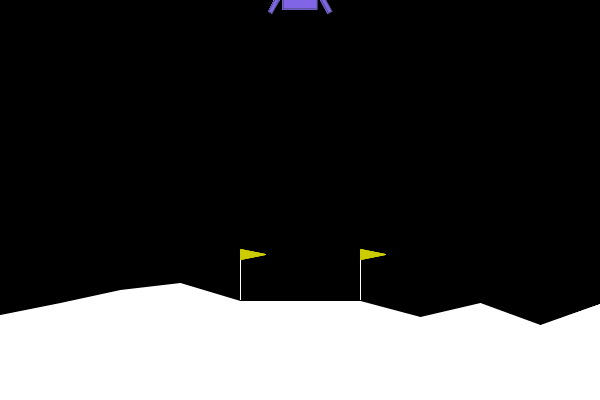

In [7]:
# Naive policies
env = gym.make("LunarLander-v2", continuous=False, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)
q_network = QNetwork(state_dim, action_dim, 32, 16).to(device)

state, info = env.reset()
done = False

for t in range(150):
    env.render_wrapper.render()

    # action = np.array([-1., 0.])
    # action = np.array([0., 0.])
    # action = env.action_space.sample()   # Random policy

    # Sample actions from the NN
    state_tensor = torch.tensor(state, device=device)
    action = torch.argmax(q_network(state_tensor)).item()

    state, reward, done, truncated, info = env.step(action)

env.close()

env.render_wrapper.make_gif("lab7_ex4_explore")

In [37]:
def train_dqn_agent(env: gym.Env,
                    q_network: torch.nn.Module,
                    optimizer: torch.optim.Optimizer,
                    loss_fn: Callable,
                    epsilon_greedy: EpsilonGreedy,
                    device: torch.device,
                    lr_scheduler: _LRScheduler,
                    num_episodes: int,
                    gamma: float,
                    batch_size: int,
                    replay_buffer: ReplayBuffer) -> List[float]:
    """
    Train the Q-network on the given environment.

    Parameters
    ----------
    env : gym.Env
        The environment to train on.
    q_network : torch.nn.Module
        The Q-network to train.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    loss_fn : callable
        The loss function to use for training.
    epsilon_greedy : EpsilonGreedy
        The epsilon-greedy policy to use for action selection.
    device : torch.device
        The device to use for PyTorch computations.
    lr_scheduler : torch.optim.lr_scheduler._LRScheduler
        The learning rate scheduler to adjust the learning rate during training.
    num_episodes : int
        The number of episodes to train for.
    gamma : float
        The discount factor for future rewards.
    batch_size : int
        The size of the batch to use for training.
    replay_buffer : ReplayBuffer
        The replay buffer storing the experiences with their priorities.

    Returns
    -------
    List[float]
        A list of cumulated rewards per episode.
    """
    episode_reward_list = []

    for episode_index in tqdm(range(1, num_episodes)):
        state, _ = env.reset()
        episode_reward = 0

        for t in itertools.count():
            # Get epislon greedy action
            action = epsilon_greedy(state)
            # Step in environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            # Calculate TD error
            state_tensor = torch.tensor(state, dtype=torch.float32, device = device)
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device = device)
            predicted_q_value = q_network(state_tensor)[action].item()
            target_q_value = reward + gamma * torch.max(q_network(next_state_tensor)).item() * (1 - done)
            td_error = abs(predicted_q_value - target_q_value)
            # Store experiences
            replay_buffer.add(state, action, reward, next_state, done, -td_error)
            if (len(replay_buffer) > batch_size):
                # Sample experiences
                states, actions, rewards, next_states, dones, _ = replay_buffer.sample(batch_size)
                # Convert numpy arrays to tensors
                states_tensor = torch.tensor(states, dtype=torch.float32).to(device)
                actions_tensor = torch.tensor(actions, dtype=torch.int64).to(device)
                next_states_tensor = torch.tensor(next_states, dtype=torch.float32).to(device)
                rewards_tensor = torch.tensor(rewards, dtype=torch.float32).to(device)
                dones_tensor = torch.tensor(dones, dtype=torch.int8).to(device)
                # Set target
                y = rewards_tensor + gamma * torch.max(q_network(next_states_tensor), axis = 1).values * (1 - dones_tensor)
                y = y.unsqueeze(1)
                # Set estimate
                # y_hat = q_network(states_tensor)
                y_hat = torch.gather(q_network(states_tensor), 1, actions_tensor.view(-1,1))
                # Compute loss
                loss = loss_fn(y, y_hat)
                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
            # Accumulate rewards
            episode_reward += reward
            # Update state
            state = next_state
            # Check if done
            if (done):
                break
        episode_reward_list.append(episode_reward)
        epsilon_greedy.decay_epsilon()

    return episode_reward_list

In [40]:
#Train
env = gym.make("LunarLander-v2", continuous=False, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n.item()

# NUMBER_OF_TRAININGS = 20
dqn1_trains_result_list = [[], [], []]

for train_index in range(1):

    # Instantiate required objects

    q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn_agent(env,
                                           q_network,
                                           optimizer,
                                           loss_fn,
                                           epsilon_greedy,
                                           device,
                                           lr_scheduler,
                                           num_episodes=100,
                                           gamma=0.9,
                                           batch_size=128,
                                           replay_buffer=replay_buffer)
    dqn1_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn1_trains_result_list[1].extend(episode_reward_list)
    dqn1_trains_result_list[2].extend([train_index for _ in episode_reward_list])

dqn1_trains_result_df = pd.DataFrame(np.array(dqn1_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn1_trains_result_df["agent"] = "DQN 2013"

# Save the action-value estimation function

torch.save(q_network, "dqn_q_network.pth")

env.close()

  0%|          | 0/99 [00:00<?, ?it/s]

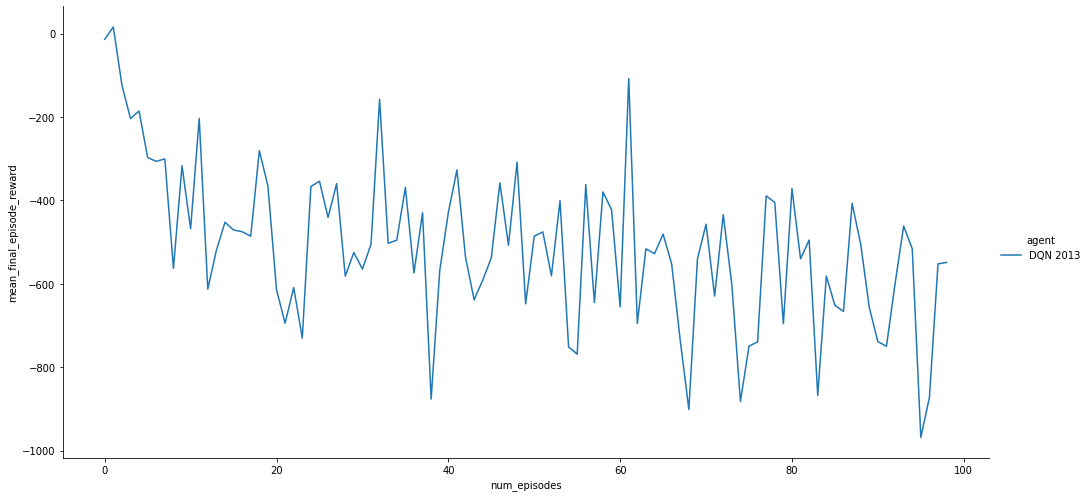

In [11]:
all_trains_result_df = pd.concat([dqn1_trains_result_df])
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", data=all_trains_result_df, height=7, aspect=2)